In [1]:
!pip install duckdb


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [6]:
import duckdb
conn = duckdb.connect()
query = '''
SELECT *
FROM read_csv_auto('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv')
'''
df = conn.execute(query).df()

In [8]:
df.describe()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,num_doors,fuel_efficiency_mpg
count,9704.000000,9222.0,8996.0,9704.000000,8774.000000,9704.000000,9202.0,9704.000000
mean,199.708368,3.962481,149.657292,3001.280993,15.021928,2011.484027,-0.006412,14.985243
std,49.455319,1.999323,29.879555,497.894860,2.510339,6.659808,1.048162,2.556468
min,10.000000,0.0,37.0,952.681761,6.000000,2000.000000,-4.0,6.200971
25%,170.000000,3.0,130.0,2666.248985,13.300000,2006.000000,-1.0,13.267459
50%,200.000000,4.0,149.0,2993.226296,15.000000,2012.000000,0.0,15.006037
75%,230.000000,5.0,170.0,3334.957039,16.700000,2017.000000,1.0,16.707965
max,380.000000,13.0,271.0,4739.077089,24.300000,2023.000000,4.0,25.967222


In [11]:
filtered_df = df[['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year', 'fuel_efficiency_mpg']]
filtered_df.describe()

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
count,9704.000000,8996.0,9704.000000,9704.000000,9704.000000
mean,199.708368,149.657292,3001.280993,2011.484027,14.985243
std,49.455319,29.879555,497.894860,6.659808,2.556468
min,10.000000,37.0,952.681761,2000.000000,6.200971
25%,170.000000,130.0,2666.248985,2006.000000,13.267459
50%,200.000000,149.0,2993.226296,2012.000000,15.006037
75%,230.000000,170.0,3334.957039,2017.000000,16.707965
max,380.000000,271.0,4739.077089,2023.000000,25.967222


<Axes: xlabel='fuel_efficiency_mpg', ylabel='Count'>

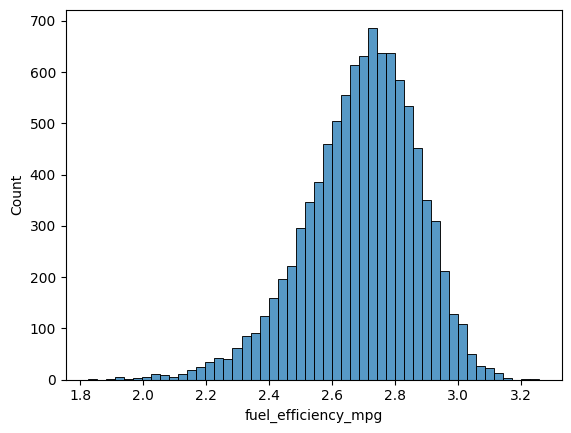

In [20]:
import seaborn as sns
import numpy as np

sns.histplot(np.log(filtered_df['fuel_efficiency_mpg']), bins=50)

In [12]:
#Q1
filtered_df.isnull().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

In [13]:
#Q2
filtered_df['horsepower'].median()

np.float64(149.0)

In [14]:
n = len(filtered_df)

n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

In [15]:
n

9704

In [16]:
n_val, n_test, n_train

(1940, 1940, 5824)

In [18]:
idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)

In [19]:
# Shuffle dataset
df_train = filtered_df.iloc[idx[:n_train]]
df_val   = filtered_df.iloc[idx[n_train: n_train+n_val]]
df_test  = filtered_df.iloc[idx[n_train+n_val:]]

print(df_train.shape, df_val.shape, df_test.shape)

(5824, 5) (1940, 5) (1940, 5)


In [21]:
y_train = np.log1p(df_train["fuel_efficiency_mpg"])
y_val   = np.log1p(df_val["fuel_efficiency_mpg"])
y_test  = np.log1p(df_test["fuel_efficiency_mpg"])

In [27]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX.astype(np.float64))
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]

In [23]:
mean_horsepower = int(df_train["horsepower"].mean())
mean_horsepower

149

In [24]:
def prepare_X_vals(df, insert_zeroes=True):
    df = df.copy()
    if (insert_zeroes):
        df = df.fillna(0.0)
    else:
        df = df.fillna(mean_horsepower)
    X = df.values
    return X

def rsme(y, y_pred):
    sqerror = (y - y_pred)**2
    mse = sqerror.mean()
    return np.sqrt(mse)

In [28]:
X_train = prepare_X_vals(df_train, True)

# Train model
w0, w = train_linear_regression(X_train, y_train)

# Get Prediction on validation dataset
X_val = prepare_X_vals(df_val, True)
y_pred = w0 + X_val.dot(w)

# Compute Metrics
round(rsme(y_pred, y_val),2), rsme(y_pred, y_val)

(np.float64(0.02), np.float64(0.022678889496995692))

In [29]:
X_train = prepare_X_vals(df_train, False)
w0, w = train_linear_regression(X_train, y_train)

# Train model
w0, w = train_linear_regression(X_train, y_train)

# Get Prediction on validation dataset
X_val = prepare_X_vals(df_val, False)
y_pred = w0 + X_val.dot(w)

# Compute Metrics
round(rsme(y_pred, y_val),2), rsme(y_pred, y_val)

(np.float64(0.02), np.float64(0.022670750750490163))

In [ ]:
#Q3 Both filling 0s and filling with mean gives the same values

In [30]:
#Q4
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r*np.eye(XTX.shape[0])
    XTX_inv = np.linalg.inv(XTX.astype(np.float64))
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]

In [32]:
# Prepare X-data
X_train = prepare_X_vals(df_train, True)

for r in [0, 0.01, 0.1, 1, 5, 10, 100]:

    # Train model
    w0, w = train_linear_regression_reg(X_train, y_train, r)

    # Get Prediction on validation dataset
    X_val = prepare_X_vals(df_val, True)
    y_pred = w0 + X_val.dot(w)

    # Compute Metrics
    print(r, round(rsme(y_pred, y_val),2), rsme(y_pred, y_val))

0 0.02 0.022678889496995692
0.01 0.02 0.022706868694212824
0.1 0.02 0.023027888786589717
1 0.02 0.02343611269212172
5 0.02 0.02350374258483359
10 0.02 0.02351052918872038
100 0.02 0.023547273431053135


In [33]:
def prep_data(df, seed):
    n = len(df)

    n_val = int(n*0.2)
    n_test = int(n*0.2)
    n_train = n - n_val - n_test

    idx = np.arange(n)
    np.random.seed(seed)
    np.random.shuffle(idx)

    df_train = df.iloc[idx[:n_train]]
    df_val   = df.iloc[idx[n_train: n_train+n_val]]
    df_test  = df.iloc[idx[n_train+n_val:]]

    y_train = np.log1p(df_train["fuel_efficiency_mpg"])
    y_val   = np.log1p(df_val["fuel_efficiency_mpg"])
    y_test  = np.log1p(df_test["fuel_efficiency_mpg"])

    return df_train, df_val, df_test, y_train, y_val, y_test

In [34]:
rsme_list = []

for seed in range(0,10):
    df_train, df_val, df_test, y_train, y_val, y_test = prep_data(filtered_df, seed)

    # Model training using Train Dataset
    X_train = prepare_X_vals(df_train, True)
    w0, w = train_linear_regression(X_train, y_train)

    # Get Prediction on validation dataset
    X_val = prepare_X_vals(df_val, True)
    y_pred = w0 + X_val.dot(w)

    # Compute Metrics
    score = rsme(y_pred, y_val)
    rsme_list.append(score)
    print(seed, score, rsme(y_pred, y_val))

# compute std of rsmes
print(round(np.std(rsme_list), 3))

0 0.018829525546763794 0.018829525546763794
1 0.019508261903268778 0.019508261903268778
2 0.01962378493668493 0.01962378493668493
3 0.019871765567191727 0.019871765567191727
4 0.017995077880838456 0.017995077880838456
5 0.01911132800474876 0.01911132800474876
6 0.019153881021998036 0.019153881021998036
7 0.019082110339966277 0.019082110339966277
8 0.02089583226834099 0.02089583226834099
9 0.01891012266444553 0.01891012266444553
0.001


In [37]:
#Q6
import pandas as pd

seed = 9

df_train, df_val, df_test, y_train, y_val, y_test = prep_data(filtered_df, seed)

df_train_full = pd.concat([df_train, df_val])
y_train_full  = np.concatenate([y_train, y_val])

X_train_full = prepare_X_vals(df_train_full, True)
w0, w = train_linear_regression_reg(X_train_full, y_train_full, r=0.001)

# Get Prediction on validation dataset
X_test = prepare_X_vals(df_test, True)
y_pred = w0 + X_test.dot(w)

# Compute Metrics
score = rsme(y_pred, y_test)
print(seed, score)

9 0.020278875175198705
